<h1>Analysing OpenStreetMap road networks</h1>

authors: Gašper Kreft, Jovana Videnović, Jaša Žnidar

This colab is covering the code for the project for the course *Machine Learning on Graphs*. The main idea behind our project was to tackle the problem of missing labels in the road segments, got from the resource [OpenStreetMap](https://www.openstreetmap.org/), by representing the road networks as graphs and building models that would work on predictions of:
- road type
- lane count
- speed limit


The code for our project is divided into sections:
- Setup of the environment, imports and utils 
- Representation of the problem as the graph
- Network analysis and Feature transformation
- Graph Machine Learning techniques and Results
- Using the models on unlabelled data

## Setup of the environment, imports and utils

### Setup

In [ ]:
!pip install osmnx
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install numpy==1.23

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 KB 692.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pa

### Imports

In [ ]:
import networkx as nx
import osmnx as ox
import torch
import numpy as np
from torch_geometric.utils.convert import from_networkx
from matplotlib import pyplot as plt
import sklearn
import random
import copy
%matplotlib inline
ox.__version__
from torch_geometric.nn import GATv2Conv
import torch.nn.functional as F
import math
from torch_geometric.nn import GCNConv
import torch_scatter
import torch.nn as nn
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)
from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
import time
from tqdm import trange
import pandas as pd
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
from torch_geometric.nn import SAGEConv

import warnings
warnings.filterwarnings('ignore')

### Utils
This section includes utils functions and code snippets, that are not directly connected to the problem domain, but will be used in this colab.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Device: {}'.format(device))

Device: cuda


In the next two code snippets, we present a code for functions used for plotting.

In [ ]:
def plot_distribution(data_dict, title=None, rotation_xticks=0, xlabel="", ylabel="Distribution (%)"):
  """
  Function that creates a bar plot, based on the parameter data_dict.
  On x-axis are keys of the dictionary data_dict, while on the y-axis are
  corresponding values, normalized so they represent the percentage.
  """
  data_dict_values = list(data_dict.values())
  sum_all_values = sum(data_dict_values)
  data_dict_percentage = [round(value * 100/sum_all_values, 2) for value in data_dict_values]
  plt.bar(data_dict.keys(), data_dict_percentage, color="skyblue",  edgecolor='blue')
  if(title):
    plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.xticks(rotation=rotation_xticks)
  plt.show()  

In [ ]:
def plot_metrics(train_loss, train_acc, val_acc, train_f1, val_f1):
  """
  Function that plots train loss on first subplot, train and validation accuracy 
  on second subplot and train and validation f1 score on third subplot. 
  """
  plt.subplots_adjust(wspace=0.5)

  plt.subplot(1, 3, 1)
  plt.xticks(fontsize=8)
  plt.yticks(fontsize=8)
  plt.plot(train_loss, label="Train")
  plt.xlabel("Epochs")
  plt.title("Train loss through epochs", fontsize=8)
  plt.legend()


  plt.subplot(1, 3, 2)
  plt.xticks(fontsize=8)
  plt.yticks(fontsize=8)
  plt.plot(train_acc, label="Train")
  plt.plot(val_acc, label="Validation")
  plt.xlabel("Epochs")
  plt.title("Comparision of accuracy \n through epochs", fontsize=8)
  plt.legend()

  plt.subplot(1, 3, 3)
  plt.xticks(fontsize=8)
  plt.yticks(fontsize=8)
  plt.plot(train_f1, label="Train")
  plt.plot(val_f1, label="Validation")
  plt.xlabel("Epochs")
  plt.title("Comparision of macro f1 \n score through epochs", fontsize=8)
  plt.legend()
  
  plt.show()


# Representation of the problem as the graph

This section introduces the problem and its representation as the graph structure.

For the rest of the colab, you can choose to work with any city available in the OpenStreetMap network. 
Minimal changes in the transformations of the data are needed if you want to perform certain data preprocessing, such as undersampling of the majority class.

In our case, we will limit ourselves to a network type *drive*, but further possibilites include *all, bike, walk etc*.

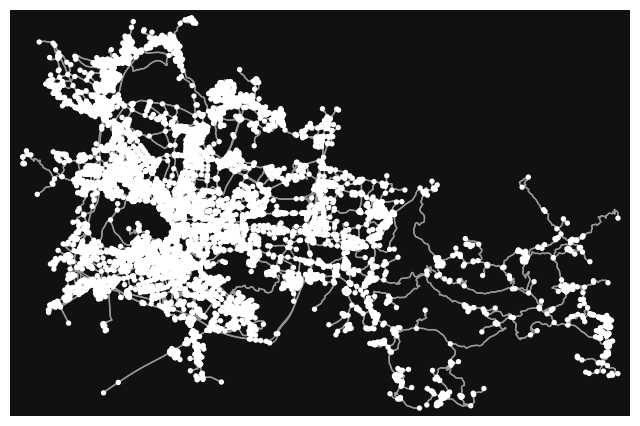

In [ ]:
# previously - network_type = drive
city = "Ljubljana, Slovenia"
G = ox.graph_from_place(city, network_type="drive")
fig, ax = ox.plot_graph(G)

We have plotted our graph representing the city, we have chosen. Nodes in the graph represent the road segments' intersections, while edges represent the road segments. 

In the next step, we will convert the graph to an undirected NetworkX graph and compute number of nodes and edges in the graph.

In [ ]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# previously
original_graph = nx.Graph(G)

original_graph_nodes = original_graph.nodes(data=True)
original_graph_edges = original_graph.edges(data=True)
print(f"Number of nodes in the graph is {len(original_graph_nodes)}.")
print(f"Number of edges in the graph is {len(original_graph_edges)}.")

Number of nodes in the graph is 6246.
Number of edges in the graph is 7895.


# Network analysis and Feature transformation

This sections is focused on deeper analysis of the network, starting from the traditional node features to further feature statistics and transformations.

At the end of this section, we will have fully prepared data to be used in our machine learning models.

## Traditional node features
This subsection explores traditional node features in the graph, which are useful to get more insight into how the road network operates and identify potential bottlenecks.

### Node degree


In graph theory, a node's degree refers to the number of edges that connect to that node.
In the case of the road networks, node degree provides information about the connectivity of the intersections. By analyzing this feature, we can identify the most connected nodes in the network - we can guess that they would represent the important crossroads.

In [ ]:
# Average degree, clustering coefficient measures
def average_degree(G):
  """
  Function that computes average degree in the graph G.
  """
  num_nodes = len(G.nodes())
  num_edges = len(G.edges())
  avg_degree = round(2*num_edges / num_nodes, 2)
  return avg_degree

def get_coords(nodes, list_nodeids, k=3):
  """
  Function that returns lat and lng coordinates of the k nodes from the given 
  list list_nodeids.
  """
  coords = [(nodes[node]["y"], nodes[node]["x"]) for node in list_nodeids][0:k]
  return coords

Average node degree is useful for understanding the overall connectivity of the network, including road network. For road network, expected average degree is between 2 and 4. Higher average degree could indicate that the city is well-connected.

In [ ]:
# Node degree
print(f"Average node degree is {average_degree(original_graph)}.")
degrees = original_graph.degree()

Average node degree is 2.53.


In the case of the city of Ljubljana, we got average node degree equal to 2.53, which was expected.
Next, we will also plot the distribution of the values of degree in the network
and compute the coordinates of the nodes (roads intersections) with high node degree.

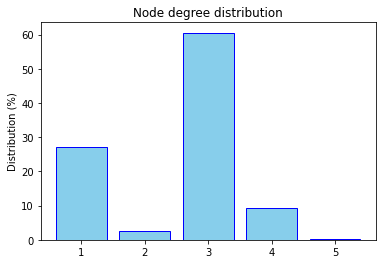

Coordinates of the nodes with high node degree: [(46.0565656, 14.5015427), (46.0575901, 14.5060117), (46.0520606, 14.4972739)]


In [ ]:
# Node degree
node_degree_sequence = sorted((degree for _, degree in degrees), reverse=True)
degree_tuples = np.unique(node_degree_sequence, return_counts=True)
degree_dict = {degree:count for degree, count in zip(degree_tuples[0], degree_tuples[1])}
plot_distribution(degree_dict, title="Node degree distribution")

# max_degree = max(degrees, key=lambda x:int(x[1]))
high_degree_nodes = [node for node, degree in degrees if degree >= 4]
# used when this was done on inverted graph
# high_degree_nodes_names = [original_graph_nodes[node]["name"] for node in high_degree_nodes if "name" in original_graph_nodes[node].keys()]
high_deg_intersection_coords = get_coords(original_graph_nodes, high_degree_nodes)
print(f"Coordinates of the nodes with high node degree: {high_deg_intersection_coords}")

In Ljubljana, nodes with high node degree correspond to important cross roads, including one on the intersection of Linhartova and Dunajska cesta; more information can be found in our Medium blog post.

### Closeness centrality

Closeness centrality is a measure of how *close* a node is to all other nodes in the network - measures the average length of the shortest path from a given node to all other nodes in the network.

In the case of the road networks, it provides a measure of how quickly we can reach other intersections from a particular intersection. Nodes with high closeness centrality could be more important in the network, and their removal could have a significant impact on the network's connectivity and efficiency.

In [ ]:
# Closeness centrality
closeness_centrality = nx.algorithms.centrality.closeness_centrality(original_graph)

In [ ]:
# # Closeness centrality
closeness_centrality_sorted = sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True)
high_closeness_centrality_ids = [node for node, _ in closeness_centrality_sorted[0:10]]
high_closeness_centrality_coords = get_coords(original_graph_nodes, high_closeness_centrality_ids)
print(f"Coordinates of the nodes with high closeness centrality coefficient: {high_closeness_centrality_coords}")

Coordinates of the nodes with high closeness centrality coefficient: [(46.0787829, 14.5329798), (46.0826217, 14.5225015), (46.0830024, 14.5197771)]


### Betweenness centrality

Betweenness centrality is a measure of a node's importance in the network based on how often it appears on the shortest path between two other nodes. In road networks, this feature can identify those intersections that play a crucial role in the networks connectivity, by connecting possible isolated parts.

In [ ]:
# Betweeness centrality
betweness_centrality = nx.algorithms.centrality.betweenness_centrality(original_graph)

In [ ]:
# # Betweeness centrality
betweeness_centrality_sorted = sorted(betweness_centrality.items(), key=lambda x:x[1], reverse=True)
high_betweeness_centrality_ids = [node for node, _ in betweeness_centrality_sorted[0:10]]
high_betweeness_centrality_coords = get_coords(original_graph_nodes, high_betweeness_centrality_ids)
print(f"Coordinates of the nodes with high closeness centrality coefficient: {high_closeness_centrality_coords}")

Coordinates of the nodes with high closeness centrality coefficient: [(46.0787829, 14.5329798), (46.0826217, 14.5225015), (46.0830024, 14.5197771)]


In the road network representing Ljubljana, we got that nearly all of the nodes with the high clustering and betweenesss centrality coefficients are lying on the motorway. This is understandable as the motorway creates a *circle* around the city, but also because the graph covers the suburb areas.

## Inverting the graph
This subsection covers the code for inverting the graph - nodes are corresponding to the road segments, while edges represent the intersections. This is needed as techiques that we will use mainly focus on node features and in the original representation, nodes (representing the crossroads) would suffer from lack of features.


Constructing a graph from the road network loses information about the structure of the roads, to partially restore it, we will calculate the angle between road segments and use it as the weight of the edge - this will be used in one of the Deep Learning techiques.

In [ ]:
def calculate_angle(og, dual, edge):
  """
  Function that calculates the angle attribute of an edge (road1,road2) 
  in dual graph (angle between roads road1 and road2).
  """
  road1 = edge[0]
  road2 = edge[1]
  intersections = [road1[0],road1[1],road2[0],road2[1]]
  vertex = og.nodes[[x for x in intersections if intersections.count(x) > 1][0]]
  other =  [x for x in intersections if intersections.count(x) <= 1]
  if(len(other)>1):
    point1 = og.nodes[other[0]]
    point2 = og.nodes[other[1]]
    vector1 = [vertex['x']-point1['x'],vertex['y']- point1['y']]
    vector2 = [vertex['x']-point2['x'],vertex['y']- point2['y']]
    angle = math.acos(np.dot(vector1,vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2)))
    return angle
  else:
    return -1

In [ ]:
def invert_graph(G):
  """
  Function that returns inverted graph, inverts nodes and edges in the graph.
  Edge directions are removed. Each edges is weighted with the calculated angle 
  between the road segments.
  """
  dual = nx.line_graph(G)
  # copy attributes manually
  dual.add_nodes_from((node, G.edges[node]) for node in dual)
  # intialize edge weight as angle between the roads
  for edge in dual.edges():
    dual.edges[edge]["angle"] = calculate_angle(G,dual,edge)
  return dual

Number of nodes in the inverted graph must be equal to the number of edges in the original graph.

In [ ]:
inverted_graph = invert_graph(original_graph)
inverted_graph_nodes = inverted_graph.nodes(data=True)
inverted_graph_edges = inverted_graph.edges(data=True)
print(f"Number of edges in the original graph is {len(original_graph_edges)}.")
print(f"Number of nodes in the inverted graph is {len(inverted_graph_nodes)}.")
print(f"Number of edges in the inverted graph is {len(inverted_graph_edges)}.")

Number of edges in the original graph is 7895.
Number of nodes in the inverted graph is 7895.
Number of edges in the inverted graph is 15116.


## Feature statistics

This subsection includes the feature statistics and plots of the feature values' distributions.

As OpenStreetMaps are based on the voluntary work, we will compute the features' statistics to determine what percentage of the data is unknown or wrongly labelled. 
For that, we will firstly determine the names of all of the features that appear on the road segments in our graph, and then compute the frequency (and normalized frequency, that represents the percentage) of all of the features.

We will also provide plots of the distribution of values for the features that we will later try to predict using ML techiques. 

In [ ]:
# constants
# road segment's features that we will predict
WANTED_FEATURES = ["maxspeed", "lanes", "highway"]
# numerical features of the road segments
NUMERICAL_FEATURES = ["length"]

In [ ]:
min_values = {}
max_values = {}
def get_all_road_features(graph):
  """
  Function returns a set of names of all road segments' features and dictionary
  where key is the road feature, and value is the set of possible values for 
  that feature. For the dictionary, we only consider road features previously 
  defined in constant WANTED_FEATURES.
  """
  road_features = set()
  road_features_dict = dict()
  for node_key, node_data in graph.nodes(data=True):
    curr_road_features = set(node_data.keys())
    road_features = road_features | curr_road_features
    
    for road_feature in curr_road_features:
      if road_feature in WANTED_FEATURES:
        if road_feature not in road_features_dict.keys():
          # dictionary, key is road_feature, value is number of occurancies of road_feature.
          road_features_dict[road_feature] = dict()
        
        if type(node_data[road_feature]) == list and not(type(node_data[road_feature]) == str):
          # if a road feature is labelled with more than 1 element, 
          # we will only consider one, and choose it randomly from all the labels.
          value = random.choice(node_data[road_feature])
        else:
          value = node_data[road_feature]

        if value in road_features_dict[road_feature].keys():
          road_features_dict[road_feature][value] += 1
        else:
          road_features_dict[road_feature][value] = 1
  return road_features, road_features_dict

def count_roads_with_feature(nodes, feature_key):
  """
  Function that returns a frequency of feature in all of the nodes.
  If a feature_key is the name of the numerical feature (previously defined in
  the constant NUMERICAL_FEATURES), function also returns minimum and maximum 
  values of that feature in the graph. 
  """
  count = 0
  min_value = -1
  max_value = -1
  for node_key, node_data in nodes:
    if feature_key in node_data:
      if(feature_key in NUMERICAL_FEATURES):
        try:
          if(float(node_data[feature_key]) < min_value or min_value == -1):
            min_value = float(node_data[feature_key])
          if(float(node_data[feature_key]) > max_value or max_value == -1):
            max_value = float(node_data[feature_key])
        except:
          pass
      count += 1
  if(feature_key in NUMERICAL_FEATURES):
    return count, min_value, max_value
  return count

def info_about_features(nodes, all_features):
  """
  Function prints the frequency for all the features in the graph.
  """
  for feature_name in all_features:
    if(feature_name in NUMERICAL_FEATURES):
      count, min_values[feature_name], max_values[feature_name] = count_roads_with_feature(nodes, feature_name)
      print("{}: {} (Percentage: {:.1%})".format(feature_name, count, count/len(inverted_graph_nodes)))
      print(f"Minimum value: {min_values[feature_name]}, maximum value:{max_values[feature_name]}")
    else:
      count = count_roads_with_feature(nodes, feature_name)
      print("{}: {} (Percentage: {:.1%})".format(feature_name, count, count/len(inverted_graph_nodes)))

In [ ]:
all_features, all_features_dict = get_all_road_features(inverted_graph)
info_about_features(nodes=inverted_graph_nodes, all_features=all_features)

length: 7895 (Percentage: 100.0%)
Minimum value: 1.901, maximum value:4653.826999999998
reversed: 7895 (Percentage: 100.0%)
geometry: 6341 (Percentage: 80.3%)
tunnel: 35 (Percentage: 0.4%)
lanes: 2980 (Percentage: 37.7%)
width: 77 (Percentage: 1.0%)
access: 96 (Percentage: 1.2%)
osmid: 7895 (Percentage: 100.0%)
highway: 7895 (Percentage: 100.0%)
oneway: 7895 (Percentage: 100.0%)
maxspeed: 3466 (Percentage: 43.9%)
junction: 254 (Percentage: 3.2%)
ref: 394 (Percentage: 5.0%)
name: 6536 (Percentage: 82.8%)
bridge: 219 (Percentage: 2.8%)


We will now have a deeper look at the features that will be meaningful for the future ML techiques:
- [length](https://wiki.openstreetmap.org/wiki/Key:length) - road segment length, in meters. We have computed minimum and maximum value for this feature in the dataset, which will be used for the normalization later.
- [maxspeed](https://wiki.openstreetmap.org/wiki/Key:maxspeed) - maximum legal speed limit on a road segment, in km/h.
- [highway](https://wiki.openstreetmap.org/wiki/Key:highway) - main key for identifying any kind of a road, street or path. Even though we can see that all road segments are covered with this label, we will discover that a high percent of the roads are labelled as *unclassifed*.
- [oneway](https://wiki.openstreetmap.org/wiki/Key:oneway) - used when the road segment can be used in one direction by vehicles.
- [lanes](https://wiki.openstreetmap.org/wiki/Key) - indicates how many traffic lanes there are.

In the next sections, we will use ML techiques to create models to predict missing labels for features maxspeed, highway and lanes. However, firstly we will in next few code snippets plot the distribution of these three features.

In [ ]:
maxspeed_feature = all_features_dict["maxspeed"]
lanes_feature = all_features_dict["lanes"]
roads_feature = all_features_dict["highway"]

If the values of the feature are numerical, we can sort them, to get a better looking plot.

In [ ]:
def sort_numerical_feature(feature_dict):
  """
  Function that returns ascending sorted feature_dict, by values.
  """
  return dict(sorted(feature_dict.items(), key=lambda x:int(x[0])))

In [ ]:
maxspeed_feature_processed = sort_numerical_feature(maxspeed_feature) 
lanes_feature_processed = sort_numerical_feature(lanes_feature) 

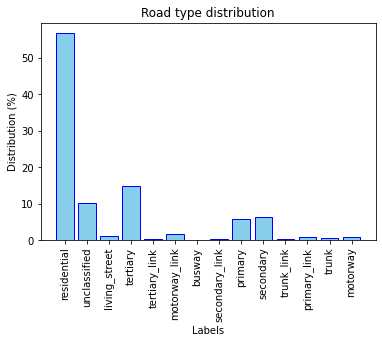

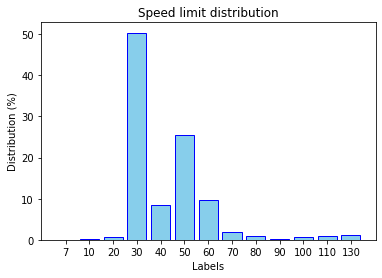

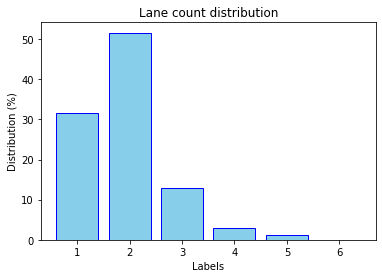

In [ ]:
plot_distribution(roads_feature, title="Road type distribution", rotation_xticks=90, xlabel="Labels")
plot_distribution(maxspeed_feature_processed, title="Speed limit distribution", xlabel="Labels")
plot_distribution(lanes_feature_processed, title="Lane count distribution", xlabel="Labels")

From the distribution plot, we can see that all three features contain values that with respect to the percentage, highly differ from the others.
Having that in mind, we will in the next subsection perform feature transformations to ensure more balanced distributions and remove outliers.

## Feature transformations

This subsection covers the feature transformation. Feature values can be merged, transformed or normalized to assure possibly more even distribution and therefore better performance of the techniqeus to be used.

First, we will initialize the dictionary, that will define the transformations for merging different feature values into one, and then apply function for merging and function for removal of the values that correspond to *unknown* or *unclassified*. 

In [ ]:
# constants for merging different classes
merge_road = {
    "motorway":["primary", "primary_link", "secondary", "secondary_link",
                "motorway_link", "trunk", "trunk_link"],
    "residential":["living_street"], 
    "tertiary":["tertiary_link"],
    "unknown":["busway", "unclassified"]    
}

def merge_features(feature_dict, merge_transforms):
  """
  Function returns feature_dict_merged, created from feature_dict, with 
  performed merging of different feature values, with respect to the parameter 
  merge_transforms.
  """
  feature_dict_merged = feature_dict.copy()
  for tr_to, tr_from_list in merge_transforms.items():
      if not(tr_to in feature_dict_merged.keys()):
          feature_dict_merged[tr_to] = 0
      for tr_from in tr_from_list:
          if tr_from in feature_dict.keys():
              feature_dict_merged[tr_to] += feature_dict_merged[tr_from]
              del feature_dict_merged[tr_from]
  return feature_dict_merged

def remove_unknown_features(feature_dict, delete_labels):
  """
  Function returns new dictionary, created from feature_dict, with 
  performed removal of feature values defined in delete_labels.
  """
  feature_dict_copy = feature_dict.copy()
  for feature in feature_dict.keys():
    if(feature in delete_labels):
      del feature_dict_copy[feature]
  return feature_dict_copy


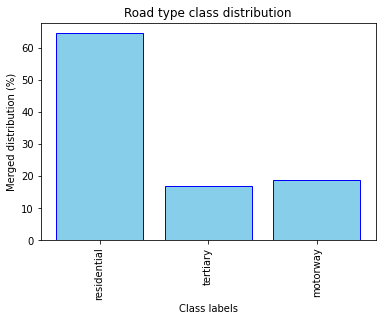

In [ ]:
roads_feature_merged = merge_features(roads_feature, merge_road)
roads_feature_merged = remove_unknown_features(roads_feature_merged, ["unknown"])
plot_distribution(roads_feature_merged, title="Road type class distribution", rotation_xticks=90, xlabel="Class labels", ylabel="Merged distribution (%)")

In the case of Ljubljana, we can see that we have assured a more balanced distribution with performing merge transformation. Still, residential road networks are dominanting the distribution.

In the next code snippet, we define dictionary needed for feature transformations for ensuring better performance of the ML models.
Bellow, we list the transformations, we applied:
- highway - transform motorway, residential, tertiary to (0, 1, 2). 
- oneway - transform True to 1, False to 0.
- lanes - consider only lanes with labels {1, 2, 3, 4}
- length - normalizing, transforming values from range (min_length, max_length) to range (0, 1)
- maxspeed - transforming values {10, 20, ..., 130} to {0, 1, ..., 13}

In [ ]:
# constants for feature transformation
# defines the wanted features to be used in following ML techiques.
wanted_features = ['highway','oneway','lanes','length', 'maxspeed', 'reversed']

# transformations
transformations = {
    "highway":{
            "motorway":0, 
            "primary":0,
            "primary_link":0, 
            "secondary":0, 
            "secondary_link":0,
            "motorway_link":0, 
            "trunk":0, 
            "trunk_link":0,
            "residential":1,
            "living_street":1, 
            "tertiary":2,
            "tertiary_link":2,
            "unknown":-1,
            "busway":-1, 
            "unclassified":-1    
    },
    "oneway":{
        True:1,
        False:0
    },
    "reversed":{
        True:1,
        False:0
    },
    "lanes":{
        "1":0,
        "2":1,
        "3":2,
        "4":3,
        "5":-1,
        "6":-1
    },
    "maxspeed":{
      "10": 0, 
      "20": 1, 
      "30": 2, 
      "40": 3, 
      "50": 4, 
      "60": 5, 
      "70": 6, 
      "80": 7, 
      "90": 8, 
      "100": 9,
      "110": 10,
      "120": 11,
      "130": 12 
    }, 
}
normalize_features = {
    "length":{
      "min_value": min_values["length"],
      "max_value": max_values["length"]        
  }
}

Next, we define function to apply previously defined transformations to one feature of the node, and also a function that transforms all the features from a node.

In [ ]:
def transform_feature(node_data, feature_name):
  """
  Function that transforms the feature with name feature_name, with the respect
  to previously defined dictionaries transformations and normalize_features.
  Returns transformed feature values.
  """
  if(feature_name in normalize_features.keys()):
    normalize_min = normalize_features[feature_name]["min_value"]
    normalize_max = normalize_features[feature_name]["max_value"]
    feature_value = -1 if feature_name not in node_data else node_data[feature_name]
    if(isinstance(feature_value, list) and not isinstance(feature_value, str)):
      feature_value = feature_value[0]
    feature_value = float(feature_value)
    feature_value = (feature_value - normalize_min) / (normalize_max - normalize_min)
    if(feature_value < 0):
      feature_value = -1
  else:
    if feature_name not in node_data:
      feature_value = -1
    else:
      feature_data = node_data[feature_name]
      if(isinstance(feature_data, list) and not isinstance(feature_data, str)):
        feature_data = feature_data[0]
      if(feature_data not in transformations[feature_name].keys()):
        feature_value = -1
      else:
        feature_value = transformations[feature_name][feature_data]
  return feature_value

In [ ]:
# transform the features of a node
def transform_features(node_id):
  """
  Function that transforms features from the node with id node_id.
  """
  node_data = inverted_graph_nodes[node_id]
  feature_dict = {feature_name:transform_feature(node_data, feature_name) for feature_name in wanted_features}
  return feature_dict  

### Undersampling

In all three classification tasks (speed limit, road type and lane count), our classes suffers from large imbalance. To address this issue, we have implemented undersampling of the majority classes.

We firstly initialize the dictionary, that defines the undersampling probabilites (probability with which we remove certain label - set to -1 of a certain node). Keys of the dictionary are names of classes, values are dictionaries, that further define the probability with which we perform undersampling of a certain class. If name of a certain class is not present in that dictionary, that means that we do not perform undersampling on that class.

Undersampling is performed using function *undersample*, which operates on elements of a class individually - removes it's label with the probability defined in the dictionary.

In [ ]:
undersampling_prob = {
    "highway":{
        2: 0.7, 
    }, 
    "lanes":{
        1: 0.7,
        2: 0.8, 
    },
    "maxspeed":{
        3: 0.7, 
        5: 0.5
    }
}

In [ ]:
def undersample(y_elem, class_name):
  """
  Function that performs undersampling.
  """
  probs = undersampling_prob[class_name]
  if(y_elem in probs.keys()):
    prob = probs[y_elem]
    if(random.random() < prob):
      y_elem = -1
  return y_elem


### Preparation of data for ML techniqeus

In the last step, before running the ML algorithms, we finilize the preparation of the data with the function bellow, that encapsules all of the functions defined above - merging of different class labels, transformations, removing outliers etc.

In [ ]:
def get_data_for_prediction(inverted_graph, class_name, balance=False):
  """
  Function that returns data in the form of torch_geometric.Data.data instance.
  Performs transformations of the features.
  Performs undersampling of the majority class if the balance parameters is equal
  to True.
  """
  data = nx.Graph()
  curr_features = wanted_features.copy().remove(class_name)
  curr_label = class_name
  unbalanced_y = []
  for node in inverted_graph.nodes():
    feature_dict = transform_features(node)
    node_data = inverted_graph_nodes[node]
    y = feature_dict.copy()[curr_label]
    unbalanced_y.append(y)
    if(balance):
      # under sampling of the majority class
      y = undersample(y, class_name)
    del feature_dict[curr_label]
    x = list(feature_dict.values())
    data.add_node(node, x=x, y=y)

  data.add_edges_from(inverted_graph.edges.data())
  pyg_graph = from_networkx(data)
  unbalanced_y = np.array(unbalanced_y)
  balanced_y = pyg_graph.y.numpy()

  return pyg_graph

# Graph machine learning techniques and Results

This sections focuses on using different Graph Neural Network types for our prediction tasks. 

As we have stated before, in our project we have focused on 3 prediction tasks.

<h3> Road type prediction </h3>
Earlier we saw, that even though all road segments had the label *highway*, around 10% were labelled as *unknown* or *unclassified*. As well, during our exploratory analysis, using domain knowledge, we discovered that some road segments have been mislabelled. This feature is imporant for the transportation planners to optimize traffic flow or predict in what areas are certain road types needed.

<h3> Lane count predicition </h3>
In the section on feature statistics, we saw that lane count label is present in around 40% of road segments. This feature is imporant for the navigation applications to optimize the route planning. 

<h3> Maximum speed prediction </h3>
In the section on feature statistics, we saw that speed limit label is present in arount 44% of road segments. This feature can help in improving road safety, efficeny of routing etc.

In following code snippets, we will take advantage of road structure and known features to do this prediction tasks.

This section is divided into 3 subsections, covering Graph Convolution Network, GraphSAGE and Graph Attention Network. In each of the subsections, we have defined a class for a specific model, train and validation / test functions and helping functions *run_gcn*, *run_graphsage*, *run_gate*. This three functions will make running the models easier for different running settings and prediction tasks.

We use all three models on each prediction task individually, and try out all different settings. In the GraphSage and GNN we use the same dataset and features, in the GAT, besides that, we also use additional edge feature - angle between the road segments.


Each subsection, has a section on results, where we have written the results we got for graph representing Ljubljana, for all three prediction tasks, without and with performing undersampling.
As our data is imbalanced, we have evaluated our models with metrics classification accuracy and macro-averaged F1 score.

- Classification accuracy is a metric that summarizes the performance of a classification model as the number of correct predictions divided by the total number of predictions.

- Macro-averaged F1 score is computed using the arithmetic mean of all the per-class F1 scores. F1 score is a evaluation metric, that combines metrics precision and recall.

The setting of the prediction task can be determined with setting the parameters of run_* functions.

e.g., 
def run_gcn(class_name, output_dim, balance=False, show_all_epochs=True, show_metrics_plots=True)
- class_name is the name of the feature, we want to predict.
- output_dim is the parameter that should be equal to the number of classes in the prediction task.
- balance is the parameter that is True, if undersampling should be performed, otherwise False.
- show_all_epochs is the parameter that is True, if information about performance for all epochs should be printed, otherwise False.
- show_metrics_plots is the parameter that is True, if the function should also include plotting of the metrics through epochs, otherwise False.

---------

In all of the settings in all models, the data is split into 70% for training, 20% for validation, and 10% for testing. The testing data is used only for the evaluation of the best model, got from training and validation loops. Best model is determined as the one that had the highest accuracy in all epochs on the validation set.



After each finished setting of the prediction task, we print information about performance of the best model on the training, validation and testing set and provide visualizations of training and validation metrics through the epochs.

## Graph Convolution Network - GCN

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):
        super(GCN, self).__init__()

        self.convs = None
        self.bns = None
        self.softmax = None

        self.convs = torch.nn.ModuleList([GCNConv(input_dim,hidden_dim )])
        for i in range(num_layers - 2):
          self.convs.append(GCNConv(hidden_dim,hidden_dim))
                            
        self.convs.append(GCNConv(hidden_dim,output_dim))
                          
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim)])
        for i in range(num_layers - 2):
          self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        self.softmax = torch.nn.LogSoftmax(dim=1)

        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        out = None
        for i, conv in enumerate(self.convs[:-1]):
          x = conv(x, adj_t)
          x = self.bns[i](x)
          x = torch.nn.functional.relu(x)
          x = torch.nn.functional.dropout(x, p=self.dropout)

        x = self.convs[-1](x,adj_t)
        if not self.return_embeds:
          x = self.softmax(x)

        out = x
        
        return out

In [ ]:
def train_gcn(model, data, train_idx, optimizer, loss_fn):
    """
    Function that trains the model by using the given optimizer and loss_fn.
    """
    model.train()
    loss = 0
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(torch.squeeze(out[train_idx],dim=1), data.y[train_idx].reshape(-1))

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
@torch.no_grad()
def val_gcn(model, data, train_idx, val_idx, best_val=0):
    """
    Function that performs validation of the model.
    """
    model.eval()

    # The output of model on all data
    out = model(data.x, data.edge_index)

    y_pred = out.argmax(dim=-1, keepdim=True)

    # calculating metrics
    metrics_train = {}
    label_np_train = data.y[train_idx].cpu().numpy()
    pred_np_train = y_pred[train_idx, -1].cpu().numpy()
    metrics_train["acc"] = sklearn.metrics.accuracy_score(label_np_train, pred_np_train)
    metrics_train["micro_f1"] = sklearn.metrics.f1_score(label_np_train, pred_np_train, average='micro')
    metrics_train["macro_f1"] = sklearn.metrics.f1_score(label_np_train, pred_np_train, average='macro')  

    metrics_val = {}
    label_np_val = data.y[val_idx].cpu().numpy()
    pred_np_val = y_pred[val_idx, -1].cpu().numpy()
    metrics_val["acc"] = sklearn.metrics.accuracy_score(label_np_val, pred_np_val)
    metrics_val["micro_f1"] = sklearn.metrics.f1_score(label_np_val, pred_np_val, average='micro')
    metrics_val["macro_f1"] = sklearn.metrics.f1_score(label_np_val, pred_np_val, average='macro')  

    best_model = None
    if metrics_val["acc"] > best_val:
        best_model_gcn = copy.deepcopy(model)

    return metrics_train, metrics_val, best_model

In [ ]:
def run_gcn(class_name, output_dim, balance=False, show_all_epochs=True, show_metrics_plots=True):
  """
  Function to run GCN model with wanted parameters.
  """
  pyg_graph = get_data_for_prediction(inverted_graph, class_name, balance=balance)
  pyg_graph.x = pyg_graph.x.to(torch.float32) if not(isinstance(pyg_graph.x, list) and not isinstance(pyg_graph.x, str)) else pyg_graph.x.FloatTensor()
  pyg_graph.y = pyg_graph.y.long()

  pyg_graph.validate()
  # ignoring all the labels with value lower than 0
  label_mask = torch.where(pyg_graph.y < 0, False, True)

  node_idx = label_mask.nonzero()

  # spliting of the data
  num_train = int(0.7 * len(node_idx))
  num_val = int(0.2 * len(node_idx))
  num_test = len(node_idx) - num_train - num_val
  shuffle = torch.randperm(node_idx.size(0))
  train_idx = node_idx[shuffle[:num_train]]
  val_idx = node_idx[shuffle[num_train:num_train+num_val]]
  test_idx = node_idx[shuffle[num_train+num_val:]]

  data_pyg_graph = pyg_graph.to(device)

  args = {'epochs':100}
  model = GCN(input_dim=5, hidden_dim=256, output_dim=output_dim, num_layers=3,
                 dropout=0.5).to(device)
  model.reset_parameters()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  loss_fn = torch.nn.functional.nll_loss

  # variables for storing history information about metrics and best results
  best_model_gcn = None
  best_val = 0
  best_loss = None
  best_metrics_train = None
  best_metrics_val = None
  train_loss_history = []
  train_acc_history = []
  train_f1_history = []
  val_acc_history = []
  val_f1_history = []

  # performing training - validation loops
  for epoch in range(1, 1 + args["epochs"]):
    loss = train_gcn(model, data_pyg_graph, train_idx, optimizer, loss_fn)
    result = val_gcn(model, data_pyg_graph, train_idx, val_idx, best_val=best_val)
    metrics_train, metrics_val, best_model_new = result

    train_loss_history.append(loss)
    train_acc_history.append(metrics_train["acc"])
    train_f1_history.append(metrics_train["macro_f1"])
    val_acc_history.append(metrics_val["acc"])
    val_f1_history.append(metrics_val["macro_f1"])

    if metrics_val["acc"] > best_val:
        best_val = metrics_val["acc"]
        best_loss = loss
        best_model_gcn = copy.deepcopy(model)
        best_metrics_train = metrics_train.copy()
        best_metrics_val = metrics_val.copy()
    if(show_all_epochs):
      print(f'Epoch: {epoch:02d}, '
            f'Loss: {loss:.4f}, '
            f'Train accuracy: {100 * metrics_train["acc"]:.2f}%, '
            f'Valid accuracy: {100 * metrics_val["acc"]:.2f}% '
            f'Train macro f1 score: {100 * metrics_train["macro_f1"]:.2f}%, '
            f'Valid macro f1 score: {100 * metrics_val["macro_f1"]:.2f}% ')

  # printing the results of the best model on the training and validation set
  print(f'Best results '
        f'Loss: {best_loss:.4f}, '
        f'Train accuracy: {100 * best_metrics_train["acc"]:.2f}%, '
        f'Valid accuracy: {100 * best_metrics_val["acc"]:.2f}% '
        f'Train macro f1 score: {100 * best_metrics_train["macro_f1"]:.2f}%, '
        f'Valid macro f1 score: {100 * best_metrics_val["macro_f1"]:.2f}% ')

  # Evaluating the best model on the testing set
  out = best_model_gcn(data_pyg_graph.x, data_pyg_graph.edge_index)
  y_pred = out.argmax(dim=-1, keepdim=True)

  metrics_test = {}
  label_np_test = data_pyg_graph.y[test_idx].cpu().numpy()
  pred_np_test = y_pred[test_idx, -1].cpu().numpy()
  metrics_test["acc"] = sklearn.metrics.accuracy_score(label_np_test, pred_np_test)
  metrics_test["micro_f1"] = sklearn.metrics.f1_score(label_np_test, pred_np_test, average='micro')
  metrics_test["macro_f1"] = sklearn.metrics.f1_score(label_np_test, pred_np_test, average='macro')  

  # printing the results of the best model on the testing set
  print(f'Results for evaluating best model on the testing set '
        f'Test accuracy: {100 * metrics_test["acc"]:.2f}%, '
        f'Test macro f1 score: {100 * metrics_test["macro_f1"]:.2f}% ')

  if(show_metrics_plots):
    plot_metrics(train_loss_history, train_acc_history, val_acc_history, train_f1_history, val_f1_history)

  return best_model_gcn, best_metrics_val


### GCN Results

Best results Loss: 0.5052, Train accuracy: 79.72%, Valid accuracy: 78.43% Train macro f1 score: 68.37%, Valid macro f1 score: 68.65% 
Results for evaluating best model on the testing set Test accuracy: 78.93%, Test macro f1 score: 68.11% 


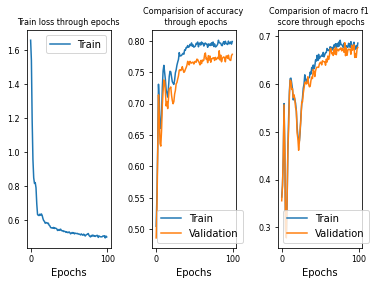

In [ ]:
_, _ = run_gcn("highway", output_dim=3, balance=False, show_all_epochs=False)

Best results Loss: 0.3641, Train accuracy: 87.82%, Valid accuracy: 88.36% Train macro f1 score: 65.21%, Valid macro f1 score: 64.53% 
Results for evaluating best model on the testing set Test accuracy: 88.87%, Test macro f1 score: 66.51% 


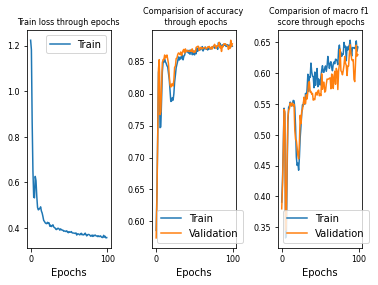

In [ ]:
_, _ = run_gcn("highway", output_dim=3, balance=True, show_all_epochs=False)

Best results Loss: 0.8270, Train accuracy: 66.70%, Valid accuracy: 66.50% Train macro f1 score: 34.15%, Valid macro f1 score: 34.06% 
Results for evaluating best model on the testing set Test accuracy: 67.00%, Test macro f1 score: 34.07% 


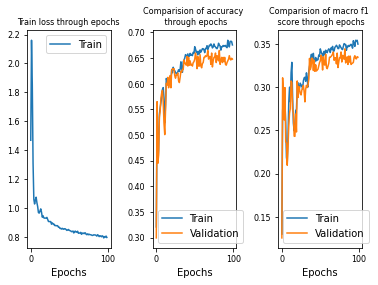

In [ ]:
_, _ = run_gcn("lanes", output_dim=4, balance=False, show_all_epochs=False)

Best results Loss: 0.7494, Train accuracy: 68.67%, Valid accuracy: 64.71% Train macro f1 score: 40.16%, Valid macro f1 score: 36.85% 
Results for evaluating best model on the testing set Test accuracy: 67.48%, Test macro f1 score: 51.32% 


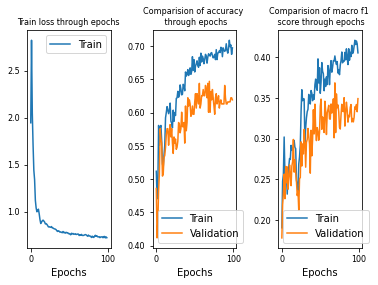

In [ ]:
_, _ = run_gcn("lanes", output_dim=4, balance=True, show_all_epochs=False)

Best results Loss: 0.7712, Train accuracy: 69.55%, Valid accuracy: 67.77% Train macro f1 score: 36.14%, Valid macro f1 score: 33.04% 
Results for evaluating best model on the testing set Test accuracy: 66.38%, Test macro f1 score: 40.12% 


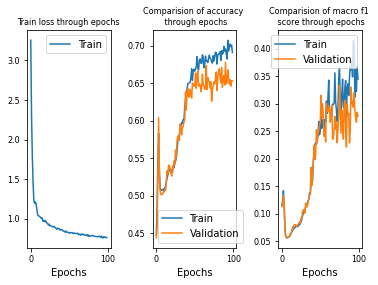

In [ ]:
best_model_gcn, best_metrics_gcn = run_gcn("maxspeed", output_dim=13, balance=False, show_all_epochs=False)

Best results Loss: 0.6727, Train accuracy: 74.58%, Valid accuracy: 78.90% Train macro f1 score: 32.40%, Valid macro f1 score: 36.66% 
Results for evaluating best model on the testing set Test accuracy: 75.08%, Test macro f1 score: 26.10% 


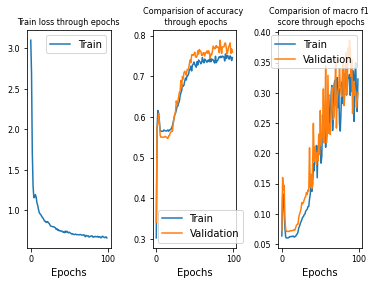

In [ ]:
_, _ = run_gcn("maxspeed", output_dim=13, balance=True, show_all_epochs=False)

## GraphSAGE

In [ ]:
class GraphSage(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
    super().__init__()
    self.convs = nn.ModuleList()
    self.convs.append(SAGEConv(input_dim, hidden_dim))
    for _ in range(num_layers - 2):
      self.convs.append(SAGEConv(hidden_dim, hidden_dim))
    self.convs.append(SAGEConv(hidden_dim, output_dim))
    self.dropout = dropout    

  def reset_parameters(self):
    for conv in self.convs:
      conv.reset_parameters()

  def forward(self, x, adjs):
    for i, (edge_index, e_id, size) in enumerate(adjs):
      target = x[:size[1]] 
      x = self.convs[i]((x, target), edge_index)
      if(i != len(self.convs) - 1):
        x = F.dropout(F.relu(x), self.dropout, training=self.training)
    return x

  def loss(self, pred, label):
    return F.cross_entropy(pred, label)

In [ ]:
def train_graphsage(model, data, train_idx, train_loader, optimizer):
  """
  Function that trains the model.
  """
  model.train()
  total_loss = 0
  all_labels = []
  all_pred = []
  for batch_size, node_id, adjs in train_loader:
    adjs = [adj.to(device) for adj in adjs]
    labels = data.y[node_id[:batch_size]]
    optimizer.zero_grad()
    
    out = model(data.x[node_id].float(), adjs)
    pred = out.argmax(dim=-1)
    
    loss = model.loss(out, labels)
    loss.backward()
    optimizer.step()
    all_labels.extend(list(labels.view(-1).cpu().detach().numpy()))
    all_pred.extend(list(pred.view(-1).cpu().detach().numpy()))
    
    total_loss += float(loss)

  all_labels = np.array(all_labels)  
  all_pred = np.array(all_pred)  

  # computing metrics for training
  total_loss /= len(train_loader)
  metrics_train = {}
  metrics_train["acc"] = sklearn.metrics.accuracy_score(all_labels, all_pred)
  metrics_train["micro_f1"] = sklearn.metrics.f1_score(all_labels, all_pred, average='micro')
  metrics_train["macro_f1"] = sklearn.metrics.f1_score(all_labels, all_pred, average='macro')  
  return total_loss, metrics_train

def validation_graphsage(model, data, val_idx, val_loader, best_val):
  """
  Function that performs validation of the model.
  """
  total_loss = 0
  all_labels = []
  all_pred = []

  for batch_size, node_id, adjs in val_loader:
    adjs = [adj.to(device) for adj in adjs]
    labels = data.y[node_id[:batch_size]]
    
    out = model(data.x[node_id].float(), adjs)
    pred = out.argmax(dim=-1)

    loss = model.loss(out, labels)
    total_loss += float(loss)
    all_labels.extend(list(labels.view(-1).cpu().detach().numpy()))
    all_pred.extend(list(pred.view(-1).cpu().detach().numpy()))
    
    total_loss += float(loss)

  all_labels = np.array(all_labels)  
  all_pred = np.array(all_pred)  

  # computing metrics for validation
  total_loss /= len(val_loader)
  metrics_val = {}
  metrics_val["acc"] = sklearn.metrics.accuracy_score(all_labels, all_pred)
  metrics_val["micro_f1"] = sklearn.metrics.f1_score(all_labels, all_pred, average='micro')
  metrics_val["macro_f1"] = sklearn.metrics.f1_score(all_labels, all_pred, average='macro')  

  best_model = None
  if metrics_val["acc"] > best_val:
    best_model = copy.deepcopy(model)
  return total_loss, metrics_val, best_model
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [ ]:
def run_graphsage(class_name, output_dim, balance=False, show_all_epochs=True, show_metrics_plots=True):
  pyg_graph = get_data_for_prediction(inverted_graph, class_name, balance=balance)
  pyg_graph.x = pyg_graph.x.to(torch.float32) if not(isinstance(pyg_graph.x, list) and not isinstance(pyg_graph.x, str)) else pyg_graph.x.FloatTensor()
  pyg_graph.y = pyg_graph.y.long()

  pyg_graph.validate()

  # ignoring all the labels with value smaller than 0
  label_mask = torch.where(pyg_graph.y < 0, False, True)

  # spliting the data into train, validation and test sets
  node_idx = label_mask.nonzero()
  num_train = int(0.7 * len(node_idx))
  num_val = int(0.2 * len(node_idx))
  num_test = len(node_idx) - num_train - num_val
  shuffle = torch.randperm(node_idx.size(0))
  train_idx = node_idx[shuffle[:num_train]]
  val_idx = node_idx[shuffle[num_train:num_train+num_val]]
  test_idx = node_idx[shuffle[num_train+num_val:]]

  data = pyg_graph.to(device)

  # creating train, validation and test loader using NeighborSampler
  train_loader = NeighborSampler(data.edge_index, node_idx=train_idx,
                                sizes=[-1, -1], batch_size=64,
                                shuffle=True, num_workers=6, drop_last=True)
  val_loader = NeighborSampler(data.edge_index, node_idx=val_idx,
                              sizes=[-1, -1], batch_size=64,
                              shuffle=True, num_workers=6, drop_last=True)
  test_loader = NeighborSampler(data.edge_index, node_idx=test_idx,
                              sizes=[-1, -1], batch_size=64,
                              shuffle=True, num_workers=6, drop_last=True)

  # Model Instantiation
  model = GraphSage(input_dim=5, hidden_dim=32, output_dim=output_dim, num_layers=2, dropout=0)
  model.to(device)
  model.reset_parameters()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  # variables, used for saving history data about metrics and best model's metrics
  train_loss_history = []
  train_acc_history = []
  train_f1_history = []
  val_acc_history = []
  val_f1_history = []
  best_val = 0
  best_model_sage = None
  best_metrics_train = {}
  best_metrics_val = {}
  best_loss = None

  # running training - validation loops
  for epoch in range(1, 101):
    train_loss, metrics_train = train_graphsage(model, data, train_idx, train_loader, optimizer)
    val_loss, metrics_val, best_model_new = validation_graphsage(model, data, val_idx, val_loader, best_val)

    train_loss_history.append(train_loss)
    train_acc_history.append(metrics_train["acc"])
    train_f1_history.append(metrics_train["macro_f1"])
    val_acc_history.append(metrics_val["acc"])
    val_f1_history.append(metrics_val["macro_f1"])

    if metrics_val["acc"] > best_val:
      best_val = metrics_val["acc"]
      best_loss = train_loss
      best_model_sage = copy.deepcopy(best_model_new)
      best_metrics_train = metrics_train.copy()
      best_metrics_val = metrics_val.copy()
      if(show_all_epochs):
        print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train accuracy: {100 * metrics_train["acc"]:.2f}%, '
          f'Valid accuracy: {100 * metrics_val["acc"]:.2f}% '
          f'Train macro f1 score: {100 * metrics_train["macro_f1"]:.2f}%, '
          f'Valid macro f1 score: {100 * metrics_val["macro_f1"]:.2f}% ')

  # Printing training and validation metrics got from the best model  
  print(f'Best results '
      f'Loss: {best_loss:.4f}, '
      f'Train accuracy: {100 * best_metrics_train["acc"]:.2f}%, '
      f'Valid accuracy: {100 * best_metrics_val["acc"]:.2f}% '
      f'Train macro f1 score: {100 * best_metrics_train["macro_f1"]:.2f}%, '
      f'Valid macro f1 score: {100 * best_metrics_val["macro_f1"]:.2f}% ')
  
  # Evaluating the best model on the testing set
  all_labels = []
  all_pred = []
  for batch_size, node_id, adjs in test_loader:
    adjs = [adj.to(device) for adj in adjs]
    labels = data.y[node_id[:batch_size]]
    out = best_model_sage(data.x[node_id].float(), adjs)
    pred = out.argmax(dim=-1)
    
    all_labels.extend(list(labels.view(-1).cpu().detach().numpy()))
    all_pred.extend(list(pred.view(-1).cpu().detach().numpy()))
    
  labels_np_test = np.array(all_labels)  
  pred_np_test = np.array(all_pred)  

  metrics_test = {}
  metrics_test["acc"] = sklearn.metrics.accuracy_score(labels_np_test, pred_np_test)
  metrics_test["micro_f1"] = sklearn.metrics.f1_score(labels_np_test, pred_np_test, average='micro')
  metrics_test["macro_f1"] = sklearn.metrics.f1_score(labels_np_test, pred_np_test, average='macro')  

  print(f'Results for evaluating best model on the testing set '
        f'Test accuracy: {100 * metrics_test["acc"]:.2f}%, '
        f'Test macro f1 score: {100 * metrics_test["macro_f1"]:.2f}% ')
  
  if(show_metrics_plots):
    plot_metrics(train_loss_history, train_acc_history, val_acc_history,
                 train_f1_history, val_f1_history)
  
  return best_model_sage


### GraphSAGE - Results

Best results Loss: 0.3709, Train accuracy: 85.75%, Valid accuracy: 84.59% Train macro f1 score: 77.58%, Valid macro f1 score: 77.38% 
Results for evaluating best model on the testing set Test accuracy: 88.64%, Test macro f1 score: 81.43% 


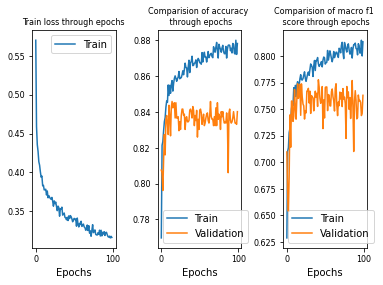

In [ ]:
_ = run_graphsage("highway", output_dim=3, balance=False, show_all_epochs=False)

Best results Loss: 0.2130, Train accuracy: 93.01%, Valid accuracy: 90.79% Train macro f1 score: 74.85%, Valid macro f1 score: 74.24% 
Results for evaluating best model on the testing set Test accuracy: 92.53%, Test macro f1 score: 74.16% 


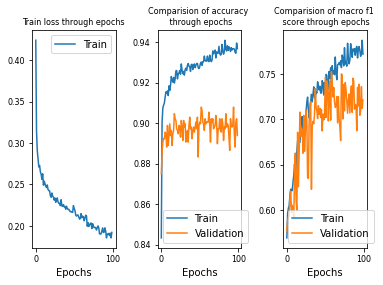

In [ ]:
_ = run_graphsage("highway", output_dim=3, balance=True, show_all_epochs=False)

Best results Loss: 0.6426, Train accuracy: 74.56%, Valid accuracy: 71.88% Train macro f1 score: 47.54%, Valid macro f1 score: 38.92% 
Results for evaluating best model on the testing set Test accuracy: 78.52%, Test macro f1 score: 43.11% 


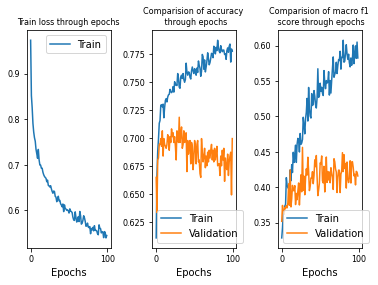

In [ ]:
_ = run_graphsage("lanes", output_dim=4, balance=False, show_all_epochs=False)

Best results Loss: 0.5230, Train accuracy: 79.60%, Valid accuracy: 78.12% Train macro f1 score: 55.32%, Valid macro f1 score: 48.54% 
Results for evaluating best model on the testing set Test accuracy: 76.56%, Test macro f1 score: 48.40% 


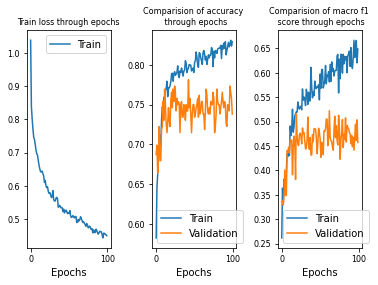

In [ ]:
_ = run_graphsage("lanes", output_dim=4, balance=True, show_all_epochs=False)

Best results Loss: 0.6253, Train accuracy: 74.49%, Valid accuracy: 74.38% Train macro f1 score: 44.43%, Valid macro f1 score: 41.29% 
Results for evaluating best model on the testing set Test accuracy: 73.44%, Test macro f1 score: 34.63% 


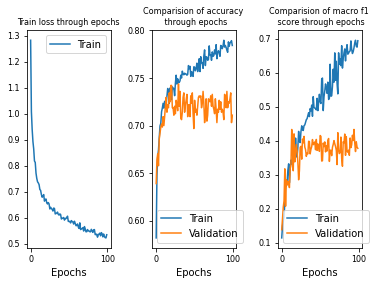

In [ ]:
_ = run_graphsage("maxspeed", output_dim=13, balance=False, show_all_epochs=False)

Best results Loss: 0.4628, Train accuracy: 81.71%, Valid accuracy: 81.08% Train macro f1 score: 64.83%, Valid macro f1 score: 45.08% 
Results for evaluating best model on the testing set Test accuracy: 78.12%, Test macro f1 score: 38.04% 


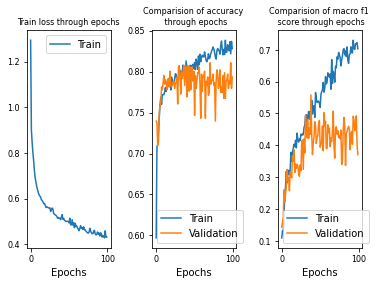

In [ ]:
best_model_sage = run_graphsage("maxspeed", output_dim=13, balance=True, show_all_epochs=False)

##GAT with edge attributes


In [ ]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()

    # edge_dim = 1 to take angles into account
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, edge_dim = 1)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1, edge_dim = 1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index, edge_attr):
    # Two Graph Attention Layers
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gat1(x, edge_index,edge_attr)
    h = F.elu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gat2(h, edge_index,edge_attr)
    return h, F.log_softmax(h, dim=1)
  
  def reset_parameters(self):
    self.gat1.reset_parameters()
    self.gat2.reset_parameters()


In [ ]:
def trainGAT(model, data, train_idx, optimizer, loss_fn):
    model.train()
    loss = 0

    optimizer.zero_grad()
    _,out = model(data.x, data.edge_index, data.angle)
    loss = loss_fn(torch.squeeze(out[train_idx],dim=1), data.y[train_idx].reshape(-1))

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
@torch.no_grad()
def valGAT(model, data, train_idx,val_idx, best_val=0):
    model.eval()
    _,out = model(data.x, data.edge_index, data.angle)
    y_pred = out.argmax(dim=-1, keepdim=True)

    # computing metrics
    metrics_train = {}
    label_np_train = data.y[train_idx].cpu().numpy()
    pred_np_train = y_pred[train_idx, -1].cpu().numpy()
    metrics_train["acc"] = sklearn.metrics.accuracy_score(label_np_train, pred_np_train)
    metrics_train["micro_f1"] = sklearn.metrics.f1_score(label_np_train, pred_np_train, average='micro')
    metrics_train["macro_f1"] = sklearn.metrics.f1_score(label_np_train, pred_np_train, average='macro')  

    metrics_val = {}
    label_np_val = data.y[val_idx].cpu().numpy()
    pred_np_val = y_pred[val_idx, -1].cpu().numpy()
    metrics_val["acc"] = sklearn.metrics.accuracy_score(label_np_val, pred_np_val)
    metrics_val["micro_f1"] = sklearn.metrics.f1_score(label_np_val, pred_np_val, average='micro')
    metrics_val["macro_f1"] = sklearn.metrics.f1_score(label_np_val, pred_np_val, average='macro')  
    
    best_model = None
    if metrics_val["acc"] > best_val:
        best_model = copy.deepcopy(model)

    return metrics_train, metrics_val, best_model

In [ ]:
def run_gat(class_name, output_dim, balance=False, show_all_epochs=True, show_metrics_plots=True):
  """
  Function to run GCN model with wanted parameters.
  """
  pyg_graph = get_data_for_prediction(inverted_graph, class_name, balance=balance)
  pyg_graph.x = pyg_graph.x.to(torch.float32) if not(isinstance(pyg_graph.x, list) and not isinstance(pyg_graph.x, str)) else pyg_graph.x.FloatTensor()
  pyg_graph.y = pyg_graph.y.long()

  pyg_graph.validate()

  # ignoring all the label's values smaller than 0
  label_mask = torch.where(pyg_graph.y < 0, False, True)

  # spliting the data into train, validation and test sets
  node_idx = label_mask.nonzero()
  num_train = int(0.7 * len(node_idx))
  num_val = int(0.2 * len(node_idx))
  num_test = len(node_idx) - num_train - num_val
  shuffle = torch.randperm(node_idx.size(0))
  train_idx = node_idx[shuffle[:num_train]]
  val_idx = node_idx[shuffle[num_train:num_train+num_val]]
  test_idx = node_idx[shuffle[num_train+num_val:]]

  data_pyg_graph = pyg_graph.to(device)

  args = {'epochs':100}

  model = GAT(dim_in=5, dim_h=100, dim_out=output_dim,heads=4).to(device)
  model.reset_parameters()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  loss_fn = torch.nn.functional.nll_loss

  # variables for saving historic data about the metrics, and best models' metrics
  best_model_gat = None
  best_val = 0
  best_loss = None
  best_metrics_train = None
  best_metrics_val = None
  train_loss_history = []
  train_acc_history = []
  train_f1_history = []
  val_acc_history = []
  val_f1_history = []

  # running training and validation loops
  for epoch in range(1, 1 + args["epochs"]):
    loss = trainGAT(model, data_pyg_graph, train_idx, optimizer, loss_fn)
    result = valGAT(model, data_pyg_graph, train_idx, val_idx, best_val=best_val)
    metrics_train, metrics_val, best_model_new = result
    train_acc_history.append(metrics_train["acc"])
    train_f1_history.append(metrics_train["macro_f1"])
    val_acc_history.append(metrics_val["acc"])
    val_f1_history.append(metrics_val["macro_f1"])
    train_loss_history.append(loss)  
    if metrics_val["acc"] > best_val:
        best_val = metrics_val["acc"]
        best_loss = loss
        best_model_gat = copy.deepcopy(best_model_new)
        best_metrics_train = metrics_train.copy()
        best_metrics_val = metrics_val.copy()
    if(show_all_epochs):
      print(f'Epoch: {epoch:02d}, '
            f'Loss: {loss:.4f}, '
            f'Train accuracy: {100 * metrics_train["acc"]:.2f}%, '
            f'Valid accuracy: {100 * metrics_val["acc"]:.2f}% '
            f'Train macro f1 score: {100 * metrics_train["macro_f1"]:.2f}%, '
            f'Valid macro f1 score: {100 * metrics_val["macro_f1"]:.2f}% ')
  
  # Printing training and validation metrics got with best model
  print(f'Best results '
        f'Loss: {best_loss:.4f}, '
        f'Train accuracy: {100 * best_metrics_train["acc"]:.2f}%, '
        f'Valid accuracy: {100 * best_metrics_val["acc"]:.2f}% '
        f'Train macro f1 score: {100 * best_metrics_train["macro_f1"]:.2f}%, '
        f'Valid macro f1 score: {100 * best_metrics_val["macro_f1"]:.2f}% ')
  
  # Evaluating the best model on the testing set
  _, out = best_model_gat(data_pyg_graph.x, data_pyg_graph.edge_index, data_pyg_graph.angle)
  y_pred = out.argmax(dim=-1, keepdim=True)

  metrics_test = {}
  label_np_test = data_pyg_graph.y[test_idx].cpu().numpy()
  pred_np_test = y_pred[test_idx, -1].cpu().numpy()
  metrics_test["acc"] = sklearn.metrics.accuracy_score(label_np_test, pred_np_test)
  metrics_test["micro_f1"] = sklearn.metrics.f1_score(label_np_test, pred_np_test, average='micro')
  metrics_test["macro_f1"] = sklearn.metrics.f1_score(label_np_test, pred_np_test, average='macro')  

  print(f'Results for evaluating best model on the testing set '
        f'Test accuracy: {100 * metrics_test["acc"]:.2f}%, '
        f'Test macro f1 score: {100 * metrics_test["macro_f1"]:.2f}% ')
  
  if(show_metrics_plots):
    plot_metrics(train_loss_history, train_acc_history, val_acc_history, train_f1_history, val_f1_history)
  
  return best_model_gat

### GAT results

Best results Loss: 0.4446, Train accuracy: 84.15%, Valid accuracy: 82.78% Train macro f1 score: 75.04%, Valid macro f1 score: 74.06% 
Results for evaluating best model on the testing set Test accuracy: 81.19%, Test macro f1 score: 72.06% 


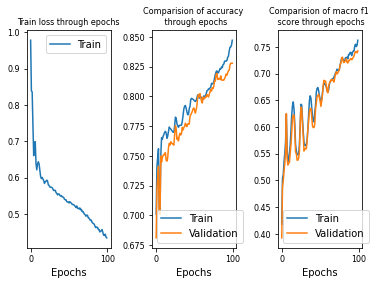

In [ ]:
_ = run_gat("highway",output_dim=3, balance=False, show_all_epochs=False)

Best results Loss: 0.2787, Train accuracy: 91.12%, Valid accuracy: 92.33% Train macro f1 score: 62.68%, Valid macro f1 score: 62.46% 
Results for evaluating best model on the testing set Test accuracy: 91.63%, Test macro f1 score: 60.94% 


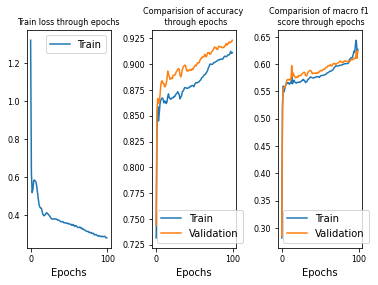

In [ ]:
_ = run_gat("highway", output_dim=3, balance=True, show_all_epochs=False)

Best results Loss: 0.8355, Train accuracy: 66.20%, Valid accuracy: 63.28% Train macro f1 score: 38.32%, Valid macro f1 score: 36.47% 
Results for evaluating best model on the testing set Test accuracy: 61.28%, Test macro f1 score: 36.34% 


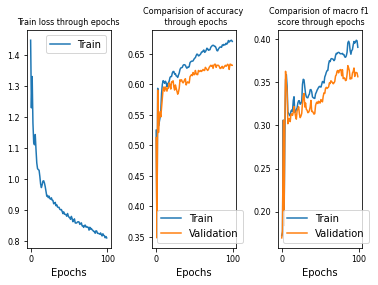

In [ ]:
_ = run_gat("lanes", output_dim=4, balance=False, show_all_epochs=False)

Best results Loss: 0.6924, Train accuracy: 75.51%, Valid accuracy: 73.23% Train macro f1 score: 44.22%, Valid macro f1 score: 37.63% 
Results for evaluating best model on the testing set Test accuracy: 69.23%, Test macro f1 score: 40.91% 


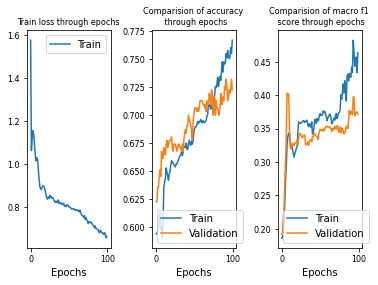

In [ ]:
_ = run_gat("lanes", output_dim=4, balance=True, show_all_epochs=False)

Best results Loss: 0.6937, Train accuracy: 75.45%, Valid accuracy: 72.69% Train macro f1 score: 31.57%, Valid macro f1 score: 29.64% 
Results for evaluating best model on the testing set Test accuracy: 69.25%, Test macro f1 score: 35.19% 


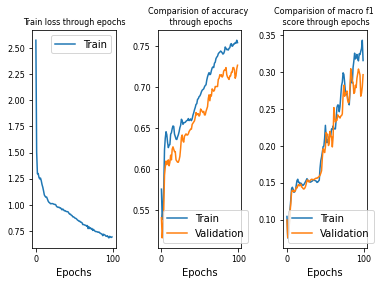

In [ ]:
_ = run_gat("maxspeed", output_dim=13, balance=False, show_all_epochs=False)

Best results Loss: 0.6098, Train accuracy: 80.56%, Valid accuracy: 80.06% Train macro f1 score: 31.65%, Valid macro f1 score: 31.28% 
Results for evaluating best model on the testing set Test accuracy: 78.39%, Test macro f1 score: 24.39% 


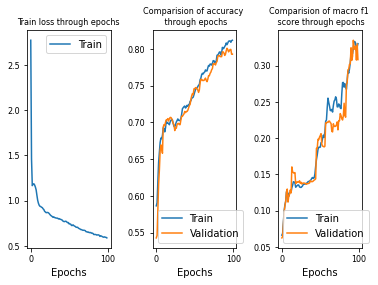

In [ ]:
best_model_gat= run_gat("maxspeed", output_dim=13, balance=True, show_all_epochs=False)

# Using the models on unlabelled data

Let's use the models to see how will they predict the speed limit on unlabeled roads.

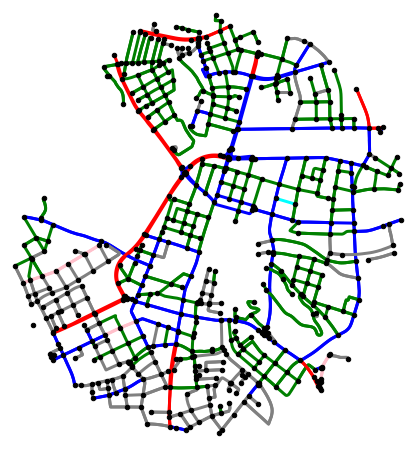

In [ ]:
subgraph = ox.graph_from_place("Slovenska cesta, Ljubljana, Slovenia", network_type="drive",retain_all=True, buffer_dist=1500)

ec = []
color_dict = {"20":"cyan","30":"g","40":"pink","50":"b","60":"r","70":"orange","110":"brown"}
for edge in subgraph.edges:
  if("maxspeed" in subgraph.edges[edge].keys()):
    speed = subgraph.edges[edge]["maxspeed"]
    ec.append(color_dict[speed if not isinstance(speed, list) else speed[0]])
  else: 
    ec.append('gray')

fig, ax = ox.plot_graph(subgraph, node_color='black', node_edgecolor='k', node_size=20, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3,bgcolor="w")

Unlabeled roads are colored gray

In [ ]:
nx_subgraph = nx.Graph(subgraph)
inverted_subgraph = invert_graph(nx_subgraph)

pyg_graph = get_data_for_prediction(inverted_subgraph, "maxspeed", balance=False)
pyg_graph.x = pyg_graph.x.to(torch.float32)
pyg_graph.y = pyg_graph.y.long()

Lets run best_model_gcn on the subgraph.

In [ ]:
data = pyg_graph.to(device)
out = best_model_gcn(data.x, data.edge_index)
y_pred = out.argmax(dim=-1, keepdim=True)

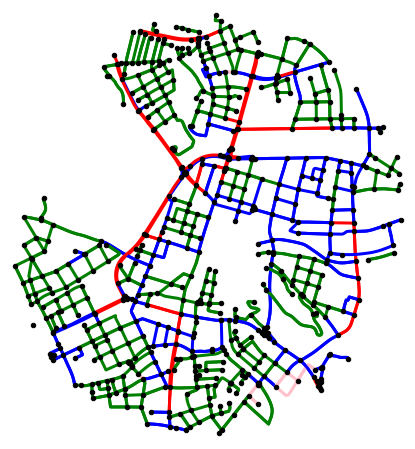

In [ ]:
color_dict = {1:"cyan",2:"g",3:"pink",4:"b",5:"r",6:"orange"}
# 20km/h -> cyan
# 30km/h -> green
# 40km/h -> pink
# 50km/h -> blue
# 60km/h -> red
# 60km/h -> orange


# Overriding maxspeed values
for i, node in enumerate(inverted_subgraph.nodes()):
    inverted_subgraph.nodes[node]["maxspeed"] = y_pred[i].item()

# Building the list of colors for every edge in original subgraph
ec = []
for u,v,k in subgraph.edges(keys=True):
  try:
    ec.append(color_dict[inverted_subgraph.nodes[(u,v)]["maxspeed"]])
  except: 
    try:
      ec.append(color_dict[inverted_subgraph.nodes[(v,u)]["maxspeed"]])
    except:
      ec.append("gray")
fig, ax = ox.plot_graph(subgraph, node_color='black', node_edgecolor='k', node_size=20, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3,bgcolor="w")